In [63]:
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import math

In [64]:
geo_data = np.loadtxt("/afs/cern.ch/user/l/lcook/WCTE_event_display/geofile_WCTE.txt", skiprows=5)  # adjust skiprows if needed

# Separate columns
tube_no      = geo_data[:, 0].astype(int)
mpmt_id     = geo_data[:, 1].astype(int)
pmt_id       = geo_data[:, 2].astype(int)
x           = geo_data[:, 3]
y           = geo_data[:, 4]
z           = geo_data[:, 5]
dir_x       = geo_data[:, 6]
dir_y       = geo_data[:, 7]
dir_z       = geo_data[:, 8]

r_pmt_vector = np.column_stack([x,y,z])
d_pmt_vector = np.column_stack([dir_x,dir_y,dir_z])

In [65]:
d_beam = np.array([0,0,1])
r_beam = np.array([0,-42.47625,-((307.5926/2)-15)])
cos_c = math.cos(42*math.pi/180)

lambda_min =0
lambda_max = (307.5926/2) - r_beam[2]


In [66]:
angle_pmt_chernenkov = np.full(len(tube_no),np.nan)
angle_pmt_chernenkov_mask = np.full(len(tube_no),False)

for i, (pmt,mpmt, r_pmt_single,d_pmt_single) in enumerate(zip(pmt_id,mpmt_id,r_pmt_vector,d_pmt_vector)):
    r_k = r_pmt_single-r_beam
    a = (1-cos_c**2)
    b = -2*r_k[2]*(1-cos_c**2)
    c = r_k[2]**2-(cos_c*np.linalg.norm(r_k))**2

    disc = (b**2) - (4*a*c)

    if disc>0:
        lambda_neg = (-b - math.sqrt(disc))/(2*a)
        lambda_pos = (-b + math.sqrt(disc))/(2*a)
        
        lambda_found = -100
        
        if (lambda_min<lambda_neg<lambda_max and r_k[2]>lambda_neg) and ~((lambda_min<lambda_pos<lambda_max) and r_k[2]>lambda_pos ) :
            lambda_found = lambda_neg
            angle_pmt_chernenkov_mask[i] = True
            # print("found neg")
            # beam_pos_neg = r_beam+(lambda_found*d_beam)
            # light_vector = r_pmt_single-beam_pos_neg
            # dot = np.dot(light_vector, d_beam)
            # norms = np.linalg.norm(light_vector) * np.linalg.norm(d_beam)
            # print("beam_pos_neg", beam_pos_neg, "light vector",r_pmt_single-beam_pos_neg, "angle to beam", math.acos(dot/norms)*180/math.pi)
            # print("does it solve equation",(lambda_found**2*a)+(lambda_found*b)+c)
            # print(math.cos(math.acos(dot/norms)),cos_c)
            # input()
        elif (lambda_min<lambda_pos<lambda_max and r_k[2]>lambda_pos) and ~((lambda_min<lambda_neg<lambda_max) and r_k[2]>lambda_neg):
            lambda_found = lambda_pos
            angle_pmt_chernenkov_mask[i] = True
            print("found pos")
            # beam_pos_pos = r_beam+(lambda_found*d_beam)
            # light_vector = r_pmt_single-beam_pos_pos
            # dot = np.dot(light_vector, d_beam)
            # norms = np.linalg.norm(light_vector) * np.linalg.norm(d_beam)
            # print("Beam pos_pos", beam_pos_pos, "light vector",r_pmt_single-beam_pos_pos, "angle to beam", math.acos(dot/norms)*180/math.pi)
            # print("does it solve equation",(lambda_found**2*a)+(lambda_found*b)+c)
            # print(math.cos(math.acos(dot/norms)),cos_c)
            # input()
        elif (lambda_min<lambda_pos<lambda_max and r_k[2]>lambda_pos) and ((lambda_min<lambda_neg<lambda_max) and r_k[2]>lambda_neg ):
            print("Both found - weird",lambda_pos,lambda_neg)
            # print("mpmt",mpmt,"pmt",pmt,"pmt coords",r_pmt_single)
            # beam_pos_neg = r_beam+(lambda_neg*d_beam)
            # light_vector = r_pmt_single-beam_pos_neg
            # dot = np.dot(light_vector, d_beam)
            # norms = np.linalg.norm(light_vector) * np.linalg.norm(d_beam)
            # print("Beam pos_neg", beam_pos_neg, "light vector",r_pmt_single-beam_pos_neg, "angle to beam", math.acos(dot/norms)*180/math.pi)

            # beam_pos_pos = r_beam+(lambda_pos*d_beam)
            # light_vector = r_pmt_single-beam_pos_pos
            # dot = np.dot(light_vector, d_beam)
            # norms = np.linalg.norm(light_vector) * np.linalg.norm(d_beam)
            # print("Beam pos_pos", beam_pos_pos, "light vector",r_pmt_single-beam_pos_pos, "angle to beam", math.acos(dot/norms)*180/math.pi)
            # input()
            
        else:
            angle_pmt_chernenkov_mask[i] = False
            angle_pmt_chernenkov[i] = np.nan
            continue
        
        if lambda_found>0:
            beam_pos = r_beam+(lambda_found*d_beam)
            light_vector = r_pmt_single-beam_pos
            dot = np.dot(light_vector, d_pmt_single)
            norms = np.linalg.norm(light_vector) * np.linalg.norm(d_pmt_single)
            cos_angle = dot/norms
            angle_pmt_chernenkov[i] = -cos_angle #negative as PMT sticking out 
            
    else:
        angle_pmt_chernenkov_mask[i] = False
        angle_pmt_chernenkov[i] = np.nan


779 / 1843 see cherenkov light at 42 deg
(2014,)


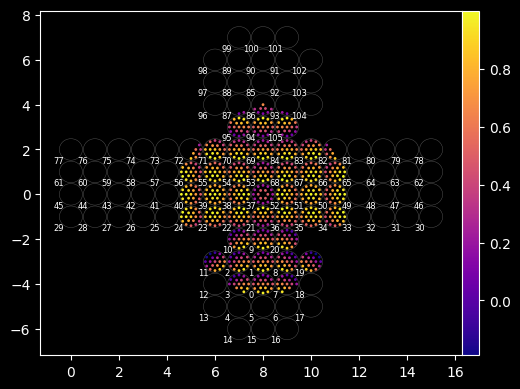

In [67]:
print(np.sum(angle_pmt_chernenkov_mask),"/",len(angle_pmt_chernenkov_mask),"see cherenkov light at 42 deg")
import sys
sys.path.append("/afs/cern.ch/user/l/lcook")
from WCTE_event_display.EventDisplay import EventDisplay
from matplotlib import colors

eventDisplay = EventDisplay() 
eventDisplay.load_mPMT_positions('mPMT_2D_projection_angles.csv')
pmt_slot = mpmt_id
pmt_pos = pmt_id-1
data_to_plot = angle_pmt_chernenkov
ev_disp_data = eventDisplay.process_data(pmt_slot,pmt_pos,data_to_plot,sum_data=True)
eventDisplay.plotEventDisplay(ev_disp_data,color_norm=colors.Normalize(), style= "dark_background")
eventDisplay.label_mPMTs(np.arange(0,106))
plt.savefig("figs/pmt_incident_angle.png",dpi=300)

In [68]:
angle_pmt_chernenkov_mask
angle_pmt_chernenkov
mpmt_id 
pmt_id = pmt_id-1

np.savez("pmt_incident_angles.npz", angle_pmt_chernenkov_mask=angle_pmt_chernenkov_mask, angle_pmt_chernenkov=angle_pmt_chernenkov, mpmt_id=mpmt_id,pmt_id=pmt_id)

